# Module

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# Load Data

In [3]:
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')
train_raw.shape, test_raw.shape

((200000, 202), (200000, 201))

In [4]:
# del train, test, data, clf
# gc.collect()

In [5]:
train = train_raw.copy()
test = test_raw.copy()

In [6]:
col_list = train.columns[2:]

In [7]:
train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

In [8]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

In [9]:
test_pb = test.iloc[pb_idx].sort_index().copy()
test_pv = test.iloc[pv_idx].sort_index().copy()

test_real = test_pb.append(test_pv)

In [10]:
data = train.append(test_real)[['ID_code', 'target'] + col_list.tolist()]

# Extract Unique Value in All Data

In [11]:
unique_df = data[['ID_code']]
con_df = data[['ID_code']]

In [12]:
for col in tqdm(col_list):
    unique_df[col] = data[col].map(((data[col].value_counts() == 1) * 1).to_dict())
    con_df[col] = data[col].map((~(data[col].value_counts() == 1) * 1).to_dict())

In [13]:
for col in tqdm(col_list):
    data[col + '_unique'] = np.around(data[col] * unique_df[col], 4)
    data[col + '_con'] = np.around(data[col] * con_df[col], 4)

In [14]:
for col in tqdm(col_list):
    data.loc[data[col + '_unique']==0, col + '_unique'] = np.nan
    data.loc[data[col + '_con']==0, col + '_con'] = np.nan

In [15]:
for col in tqdm(col_list):
    data[col + '_con_multi_counts'] = data[col + '_con'] * data[col].map(data[col].value_counts().to_dict())

## target encoding

In [16]:
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_0_con,var_1_unique,var_1_con,var_2_unique,var_2_con,var_3_unique,var_3_con,var_4_unique,var_4_con,var_5_unique,var_5_con,var_6_unique,var_6_con,var_7_unique,var_7_con,var_8_unique,var_8_con,var_9_unique,var_9_con,var_10_unique,var_10_con,var_11_unique,var_11_con,var_12_unique,var_12_con,var_13_unique,var_13_con,var_14_unique,var_14_con,var_15_unique,var_15_con,var_16_unique,var_16_con,var_17_unique,var_17_con,var_18_unique,var_18_con,var_19_unique,var_19_con,var_20_unique,var_20_con,var_21_unique,var_21_con,var_22_unique,var_22_con,var_23_unique,var_23_con,...,var_175_unique,var_175_con,var_176_unique,var_176_con,var_177_unique,var_177_con,var_178_unique,var_178_con,var_179_unique,var_179_con,var_180_unique,var_180_con,var_181_unique,var_181_con,var_182_unique,var_182_con,var_183_unique,var_183_con,var_184_unique,var_184_con,var_185_unique,var_185_con,var_186_unique,var_186_con,var_187_unique,var_187_con,var_188_unique,var_188_con,var_189_unique,var_189_con,var_190_unique,var_190_con,var_191_unique,var_191_con,var_192_unique,var_192_con,var_193_unique,var_193_con,var_194_unique,var_194_con,var_195_unique,var_195_con,var_196_unique,var_196_con,var_197_unique,var_197_con,var_198_unique,var_198_con,var_199_unique,var_199_con,var_0_con_multi_counts,var_1_con_multi_counts,var_2_con_multi_counts,var_3_con_multi_counts,var_4_con_multi_counts,var_5_con_multi_counts,var_6_con_multi_counts,var_7_con_multi_counts,var_8_con_multi_counts,var_9_con_multi_counts,var_10_con_multi_counts,var_11_con_multi_counts,var_12_con_multi_counts,var_13_con_multi_counts,var_14_con_multi_counts,var_15_con_multi_counts,var_16_con_multi_counts,var_17_con_multi_counts,var_18_con_multi_counts,var_19_con_multi_counts,var_20_con_multi_counts,var_21_con_multi_counts,var_22_con_multi_counts,var_23_con_multi_counts,var_24_con_multi_counts,var_25_con_multi_counts,var_26_con_multi_counts,var_27_con_multi_counts,var_28_con_multi_counts,var_29_con_multi_counts,var_30_con_multi_counts,var_31_con_multi_counts,var_32_con_multi_counts,var_33_con_multi_counts,var_34_con_multi_counts,var_35_con_multi_counts,var_36_con_multi_counts,var_37_con_multi_counts,var_38_con_multi_counts,var_39_con_multi_counts,var_40_con_multi_counts,var_41_con_multi_counts,var_42_con_multi_counts,var_43_con_multi_counts,var_44_con_multi_counts,var_45_con_multi_counts,var_46_con_multi_counts,var_47_con_multi_counts,var_48_con_multi_counts,var_49_con_multi_counts,var_50_con_multi_counts,var_51_con_multi_coun

In [17]:
# CALCULATE MEANS AND STANDARD DEVIATIONS
s = [0]*200
for i in range(200):
    s[i] = np.std(data['var_'+str(i)])

def getp_vec_sum(x, x_sort, y, std, c):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_pdf(data, col, x_query=None, smooth=3, s=s):
    std = s[int(col.split('_')[-1])]
    df = data.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    s, c = cols
    
    df[s] = df[s].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query, df[col].values, df[s].values, std, smooth)
    cm = getp_vec_sum(x_query, df[col].values, df[c].values, std, smooth) + 1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = np.nan
    return dg['res'].values

In [18]:
# for col in tqdm(col_list):
#     data[col + '_prob'] = get_pdf(data, col, data[col].values, 10)

In [84]:
# for col in tqdm(col_list):
#     data[col + '_value_counts'] = data[col].map(data[col].value_counts().to_dict())

In [85]:
# # 보류
# for col in tqdm(col_list):
#     lower = data[col].quantile(.4)
#     upper = data[col].quantile(.6)

#     data[col + '_qcut'] = 0
#     data.loc[(lower <= data[col]) & (data[col] <= upper), col + '_qcut'] = 1

In [86]:
# # 특정 value로 묶었을 때 *
# var = 'var_68'

# temp = data[:100][col_list].groupby(var).agg(get_order)
# temp.columns = [col[0] + '_' + col[1] + '_' + 'groupby_' + var for col in temp.columns]
# temp.reset_index(inplace=True)

In [87]:
# 통계데이터
# data['count'] = data[[col + '_unique' for col in col_list]].count(axis=1)
# data['mean'] = data[[col + '_unique' for col in col_list]].mean(axis=1)
# data['min'] = data[[col + '_unique' for col in col_list]].min(axis=1)
# data['max'] = data[[col + '_unique' for col in col_list]].max(axis=1)
# data['skew'] = data[[col + '_unique' for col in col_list]].skew(axis=1)
# data['std'] = data[[col + '_unique' for col in col_list]].std(axis=1)

In [25]:
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_0_con,var_1_unique,var_1_con,var_2_unique,var_2_con,var_3_unique,var_3_con,var_4_unique,var_4_con,var_5_unique,var_5_con,var_6_unique,var_6_con,var_7_unique,var_7_con,var_8_unique,var_8_con,var_9_unique,var_9_con,var_10_unique,var_10_con,var_11_unique,var_11_con,var_12_unique,var_12_con,var_13_unique,var_13_con,var_14_unique,var_14_con,var_15_unique,var_15_con,var_16_unique,var_16_con,var_17_unique,var_17_con,var_18_unique,var_18_con,var_19_unique,var_19_con,var_20_unique,var_20_con,var_21_unique,var_21_con,var_22_unique,var_22_con,var_23_unique,var_23_con,...,var_175_unique,var_175_con,var_176_unique,var_176_con,var_177_unique,var_177_con,var_178_unique,var_178_con,var_179_unique,var_179_con,var_180_unique,var_180_con,var_181_unique,var_181_con,var_182_unique,var_182_con,var_183_unique,var_183_con,var_184_unique,var_184_con,var_185_unique,var_185_con,var_186_unique,var_186_con,var_187_unique,var_187_con,var_188_unique,var_188_con,var_189_unique,var_189_con,var_190_unique,var_190_con,var_191_unique,var_191_con,var_192_unique,var_192_con,var_193_unique,var_193_con,var_194_unique,var_194_con,var_195_unique,var_195_con,var_196_unique,var_196_con,var_197_unique,var_197_con,var_198_unique,var_198_con,var_199_unique,var_199_con,var_0_con_multi_counts,var_1_con_multi_counts,var_2_con_multi_counts,var_3_con_multi_counts,var_4_con_multi_counts,var_5_con_multi_counts,var_6_con_multi_counts,var_7_con_multi_counts,var_8_con_multi_counts,var_9_con_multi_counts,var_10_con_multi_counts,var_11_con_multi_counts,var_12_con_multi_counts,var_13_con_multi_counts,var_14_con_multi_counts,var_15_con_multi_counts,var_16_con_multi_counts,var_17_con_multi_counts,var_18_con_multi_counts,var_19_con_multi_counts,var_20_con_multi_counts,var_21_con_multi_counts,var_22_con_multi_counts,var_23_con_multi_counts,var_24_con_multi_counts,var_25_con_multi_counts,var_26_con_multi_counts,var_27_con_multi_counts,var_28_con_multi_counts,var_29_con_multi_counts,var_30_con_multi_counts,var_31_con_multi_counts,var_32_con_multi_counts,var_33_con_multi_counts,var_34_con_multi_counts,var_35_con_multi_counts,var_36_con_multi_counts,var_37_con_multi_counts,var_38_con_multi_counts,var_39_con_multi_counts,var_40_con_multi_counts,var_41_con_multi_counts,var_42_con_multi_counts,var_43_con_multi_counts,var_44_con_multi_counts,var_45_con_multi_counts,var_46_con_multi_counts,var_47_con_multi_counts,var_48_con_multi_counts,var_49_con_multi_counts,var_50_con_multi_counts,var_51_con_multi_coun

In [26]:
train = data[~data.target.isna()]
test = data[data.target.isna()]

In [27]:
target = train['target']

In [28]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 8
}

In [33]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()
c = 5

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    
    col_names_pred = [col + '_pred' for col in col_list]
    
    trn_data = train.iloc[trn_idx]
    val_data = train.iloc[val_idx]
    te_data = test.copy()
    
    tr_y = []
    val_y = []
    te_y = []
    
    print("Make PDF Features ...")
    
    for col in tqdm(col_list):
        tr_res = np.around(get_pdf(trn_data, col, trn_data[col + '_con'].values, c), 2)
        tr_y.append(tr_res)
        
        val_res = np.around(get_pdf(trn_data, col, val_data[col + '_con'].values, c), 2)
        val_y.append(val_res)
        
        te_res = np.around(get_pdf(trn_data, col, test[col + '_con'].values, c), 2)
        te_y.append(te_res)
    
    print(np.vstack(tr_y).T * con_df.iloc[trn_data][col_list].values)
    
    break
    
    trn_data = pd.concat([trn_data.reset_index(drop=True), pd.DataFrame(np.vstack(tr_y).T * con_df.iloc[trn_data][col_list].values, columns = col_names_pred)], axis=1)
    val_data = pd.concat([val_data.reset_index(drop=True), pd.DataFrame(np.vstack(val_y).T, columns = col_names_pred)], axis=1)
    te_data = pd.concat([te_data.reset_index(drop=True), pd.DataFrame(np.vstack(te_y).T, columns = col_names_pred)], axis=1)
    
    val_data_temp = val_data.copy()
        
    trn_data = lgb.Dataset(trn_data[train_columns + col_names_pred], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(val_data[train_columns + col_names_pred], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 600)
    oof_lgb[val_idx] = clf.predict(val_data_temp[train_columns + col_names_pred], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(te_data[train_columns + col_names_pred], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns + col_names_pred
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))    
    
    print("Memory Collecting ...")
    del col_names_pred, trn_data, val_data, te_data, tr_y, val_y, te_y, tr_res, val_res, te_res, val_data_temp, clf
    gc.collect()
    
    print('\n')
            
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Make PDF Features ...


ValueError: invalid literal for int() with base 10: 'train_1'

In [38]:
con_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,train_1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,1,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
2,train_2,1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1
3,train_3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
4,train_4,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,0,0,1,1,1,1,1


In [46]:
np.place(np.vstack(tr_y).T * con_df.iloc[trn_idx][col_list].values, (np.vstack(tr_y).T * con_df.iloc[trn_idx][col_list].values) == 0, np.nan)

In [45]:
(np.vstack(tr_y).T * con_df.iloc[trn_idx][col_list].values).replace(0, np.nan)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [69]:
test.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_0_con,var_1_unique,var_1_con,var_2_unique,var_2_con,var_3_unique,var_3_con,var_4_unique,var_4_con,var_5_unique,var_5_con,var_6_unique,var_6_con,var_7_unique,var_7_con,var_8_unique,var_8_con,var_9_unique,var_9_con,var_10_unique,var_10_con,var_11_unique,var_11_con,var_12_unique,var_12_con,var_13_unique,var_13_con,var_14_unique,var_14_con,var_15_unique,var_15_con,var_16_unique,var_16_con,var_17_unique,var_17_con,var_18_unique,var_18_con,var_19_unique,var_19_con,var_20_unique,var_20_con,var_21_unique,var_21_con,var_22_unique,var_22_con,var_23_unique,var_23_con,...,var_150_con_multi_counts,var_151_con_multi_counts,var_152_con_multi_counts,var_153_con_multi_counts,var_154_con_multi_counts,var_155_con_multi_counts,var_156_con_multi_counts,var_157_con_multi_counts,var_158_con_multi_counts,var_159_con_multi_counts,var_160_con_multi_counts,var_161_con_multi_counts,var_162_con_multi_counts,var_163_con_multi_counts,var_164_con_multi_counts,var_165_con_multi_counts,var_166_con_multi_counts,var_167_con_multi_counts,var_168_con_multi_counts,var_169_con_multi_counts,var_170_con_multi_counts,var_171_con_multi_counts,var_172_con_multi_counts,var_173_con_multi_counts,var_174_con_multi_counts,var_175_con_multi_counts,var_176_con_multi_counts,var_177_con_multi_counts,var_178_con_multi_counts,var_179_con_multi_counts,var_180_con_multi_counts,var_181_con_multi_counts,var_182_con_multi_counts,var_183_con_multi_counts,var_184_con_multi_counts,var_185_con_multi_counts,var_186_con_multi_counts,var_187_con_multi_counts,var_188_con_multi_counts,var_189_con_multi_counts,var_190_con_multi_counts,var_191_con_multi_counts,var_192_con_multi_counts,var_193_con_multi_counts,var_194_con_multi_counts,var_195_con_multi_counts,var_196_con_multi_counts,var_197_con_multi_counts,var_198_con_multi_counts,var_199_con_multi_counts,var_0_prob,var_1_prob,var_2_prob,var_3_prob,var_4_prob,var_5_prob,var_6_prob,var_7_prob,var_8_prob,var_9_prob,var_10_prob,var_11_prob,var_12_prob,var_13_prob,var_14_prob,var_15_prob,var_16_prob,var_17_prob,var_18_prob,var_19_prob,var_20_prob,var_21_prob,var_22_prob,var_23_prob,var_24_prob,var_25_prob,var_26_prob,var_27_prob,var_28_prob,var_29_prob,var_30_prob,var_31_prob,var_32_prob,var_33_prob,var_34_prob,var_35_prob,var_36_prob,var_37_prob,var_38_prob,var_39_prob,var_40_prob,var_41_prob,var_42_prob,var_43_prob,var_44_prob,var_45_prob,var_46_prob,var_47_prob,var_48_prob,var_49_prob,var_50_prob,var_51_prob,var_52_prob,var_53_prob,var_54_prob,var_55_pro

In [42]:
def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_pdf_2(tr,col,x_query=None,smooth=3):
    std = tr[col].std()
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    x_query = sorted(tr[col].unique())
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
#     dg['res'] = tm/cm
#     dg.loc[cm<500,'res'] = 0.1
    dg[col] = x_query
    dg['{}_prob'.format(col)] = tm/cm
#     dg.loc[cm < 500, '{}_prob'.format(col)] = 0.1
    return dg
tr = train[col_list.tolist() +  ['target']]
te = test[col_list]
from tqdm import tqdm_notebook
for temp_col in tqdm_notebook(var_cols):
    prob = get_pdf_2(tr, temp_col)
    
    good_vals = prob.loc[prob['{}_prob'.format(temp_col)] > 0.11, temp_col]
    
    train['{}_prob_filtered'.format(temp_col)] = train[temp_col].copy()
    train.loc[~train[temp_col].isin(good_vals), '{}_prob_filtered'.format(temp_col)] = np.nan
    train.loc[~train[temp_col].isin(good_vals), '{}_prob_filtered'.format(temp_col)] = np.nan
    test['{}_prob_filtered'.format(temp_col)] = test[temp_col].copy()
    test.loc[~test[temp_col].isin(good_vals), '{}_prob_filtered'.format(temp_col)] = np.nan
    test.loc[~test[temp_col].isin(good_vals), '{}_prob_filtered'.format(temp_col)] = np.nan

In [58]:
    train['{}_prob_filtered'.format('var_0')] = train['var_0'].copy()
    train.loc[~train['var_0'].isin(good_vals), '{}_prob_filtered'.format('var_0')] = np.nan
    train.loc[~train['var_0'].isin(good_vals), '{}_prob_filtered'.format('var_0')] = np.nan

In [59]:
train.var_0_prob_filtered.value_counts(dropna=False)

NaN         161713
 14.1727         8
 13.4777         8
 13.4862         8
 13.3437         8
 13.6871         7
 13.7587         7
 13.3741         7
 14.6662         7
 13.4963         7
 15.3889         7
 13.3713         7
 13.9408         7
 13.5472         7
 13.7949         7
 13.9805         7
 14.1012         6
 13.5037         6
 14.2796         6
 13.9701         6
 15.1344         6
 14.2315         6
 13.3624         6
 13.3481         6
 13.7877         6
 13.5463         6
 14.6245         6
 14.1591         6
 13.6243         6
 13.6692         6
 14.5417         6
 14.5690         6
 14.0129         6
 14.6139         6
 14.1352         6
 14.3585         6
 13.6074         6
 13.9262         6
 13.6891         6
 15.0810         6
 13.6535         6
 13.6744         6
 13.7407         6
 13.5374         6
 14.4020         6
 13.3556         6
 13.6175         6
 14.2044         6
 13.4030         6
 13.6057         6
 14.5085         6
 13.5664         6
 13.6641    

In [60]:
test.var_0_prob_filtered.value_counts(dropna=False)

NaN         88592
 13.4321        6
 13.6614        6
 13.3336        5
 14.6351        5
 13.4395        5
 14.8109        5
 13.9408        5
 13.5113        5
 13.4419        5
 13.7792        5
 13.5733        5
 13.8335        5
 14.6488        5
 14.3500        5
 14.0070        5
 13.9595        5
 15.1818        5
 13.3358        5
 13.6336        5
 13.3680        5
 13.6965        4
 14.3135        4
 14.0814        4
 13.7471        4
 13.4908        4
 13.4522        4
 13.5799        4
 13.4194        4
 13.5577        4
 13.3592        4
 14.5530        4
 14.2484        4
 13.9154        4
 14.4913        4
 13.8757        4
 13.5620        4
 13.4233        4
 13.9886        4
 14.4521        4
 14.0972        4
 13.4273        4
 13.7905        4
 13.9748        4
 14.0532        4
 13.4215        4
 13.4350        4
 13.8423        4
 13.8129        4
 13.5209        4
 13.6337        4
 13.8390        4
 13.9347        4
 13.9691        4
 13.7103        4
 14.0610  

In [56]:
    prob = get_pdf_2(data, 'var_0')
    
    good_vals = prob.loc[prob['{}_prob'.format('var_0')] > 0.11, 'var_0']

In [57]:
good_vals

0          0.1887
3          0.5979
4          0.8935
5          0.9220
6          0.9302
7          0.9817
8          1.0100
9          1.0147
10         1.1151
11         1.1483
12         1.1563
13         1.1862
14         1.2409
15         1.2832
16         1.2944
17         1.2968
18         1.3070
19         1.3215
20         1.3350
21         1.3902
22         1.3958
23         1.4059
24         1.4449
25         1.4566
30         1.5724
31         1.5782
39         1.6659
40         1.6824
41         1.6898
42         1.6938
43         1.6945
44         1.7243
45         1.7324
78909     13.3334
78910     13.3335
78911     13.3336
78912     13.3337
78913     13.3338
78914     13.3339
78915     13.3340
78916     13.3341
78917     13.3342
78918     13.3343
78919     13.3344
78920     13.3345
78921     13.3346
78922     13.3347
78923     13.3348
78924     13.3349
78925     13.3350
78926     13.3351
78927     13.3352
78928     13.3353
78929     13.3354
78930     13.3355
78931     

In [104]:
data.tail()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_0_con,var_1_unique,var_1_con,var_2_unique,var_2_con,var_3_unique,var_3_con,var_4_unique,var_4_con,var_5_unique,var_5_con,var_6_unique,var_6_con,var_7_unique,var_7_con,var_8_unique,var_8_con,var_9_unique,var_9_con,var_10_unique,var_10_con,var_11_unique,var_11_con,var_12_unique,var_12_con,var_13_unique,var_13_con,var_14_unique,var_14_con,var_15_unique,var_15_con,var_16_unique,var_16_con,var_17_unique,var_17_con,var_18_unique,var_18_con,var_19_unique,var_19_con,var_20_unique,var_20_con,var_21_unique,var_21_con,var_22_unique,var_22_con,var_23_unique,var_23_con,...,var_150_con_multi_counts,var_151_con_multi_counts,var_152_con_multi_counts,var_153_con_multi_counts,var_154_con_multi_counts,var_155_con_multi_counts,var_156_con_multi_counts,var_157_con_multi_counts,var_158_con_multi_counts,var_159_con_multi_counts,var_160_con_multi_counts,var_161_con_multi_counts,var_162_con_multi_counts,var_163_con_multi_counts,var_164_con_multi_counts,var_165_con_multi_counts,var_166_con_multi_counts,var_167_con_multi_counts,var_168_con_multi_counts,var_169_con_multi_counts,var_170_con_multi_counts,var_171_con_multi_counts,var_172_con_multi_counts,var_173_con_multi_counts,var_174_con_multi_counts,var_175_con_multi_counts,var_176_con_multi_counts,var_177_con_multi_counts,var_178_con_multi_counts,var_179_con_multi_counts,var_180_con_multi_counts,var_181_con_multi_counts,var_182_con_multi_counts,var_183_con_multi_counts,var_184_con_multi_counts,var_185_con_multi_counts,var_186_con_multi_counts,var_187_con_multi_counts,var_188_con_multi_counts,var_189_con_multi_counts,var_190_con_multi_counts,var_191_con_multi_counts,var_192_con_multi_counts,var_193_con_multi_counts,var_194_con_multi_counts,var_195_con_multi_counts,var_196_con_multi_counts,var_197_con_multi_counts,var_198_con_multi_counts,var_199_con_multi_counts,var_0_prob,var_1_prob,var_2_prob,var_3_prob,var_4_prob,var_5_prob,var_6_prob,var_7_prob,var_8_prob,var_9_prob,var_10_prob,var_11_prob,var_12_prob,var_13_prob,var_14_prob,var_15_prob,var_16_prob,var_17_prob,var_18_prob,var_19_prob,var_20_prob,var_21_prob,var_22_prob,var_23_prob,var_24_prob,var_25_prob,var_26_prob,var_27_prob,var_28_prob,var_29_prob,var_30_prob,var_31_prob,var_32_prob,var_33_prob,var_34_prob,var_35_prob,var_36_prob,var_37_prob,var_38_prob,var_39_prob,var_40_prob,var_41_prob,var_42_prob,var_43_prob,var_44_prob,var_45_prob,var_46_prob,var_47_prob,var_48_prob,var_49_prob,var_50_prob,var_51_prob,var_52_prob,var_53_prob,var_54_prob,var_55_pro

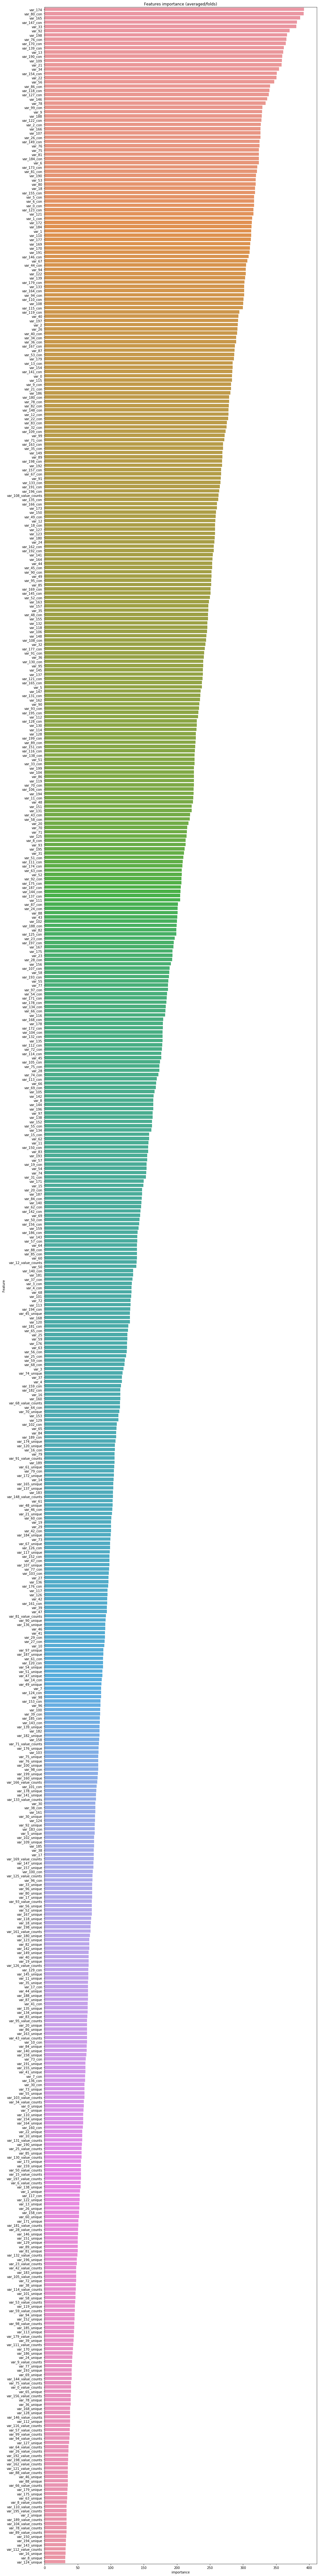

In [181]:
best_features = (feature_importance[["Feature", "importance"]]
                    .groupby("Feature")
                    .mean()
                    .sort_values(by="importance", ascending=False)[:600])

plt.figure(figsize=(14,112))
sns.barplot(x="importance", y="Feature", data=best_features.reset_index())
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [184]:
best_features.to_csv('./data_temp/feature_importance.csv',index=False)

* 7800 => 91825

In [35]:
bbiggu = train[['ID_code', 'target']]
bbiggu['pred'] = oof_lgb

In [36]:
temp = pd.read_csv('./data_temp/new_bbiggu.csv')
temp['target'] = train.target

In [37]:
roc_auc_score(bbiggu[(bbiggu.pred < 0.1)].target, bbiggu[(bbiggu.pred < 0.1)].pred), roc_auc_score(temp[temp.pred<0.1].target, temp[temp.pred<0.1].pred)

(0.7751441984398802, 0.7707841507048583)

In [23]:
roc_auc_score(bbiggu[(bbiggu.pred >= 0.1)].target, bbiggu[(bbiggu.pred >= 0.1)].pred), roc_auc_score(temp[temp.pred>=0.1].target, temp[temp.pred>=0.1].pred)

(0.8167443836875399, 0.8045344524437575)

In [24]:
bbiggu[(bbiggu.pred < 0.1) & (bbiggu.target == 1)].shape[0], temp[(temp.pred < 0.1) & (temp.target == 1)].shape[0]

(3146, 3495)

In [25]:
bbiggu[(bbiggu.pred > 0.1) & (bbiggu.target == 0)].shape[0], temp[(temp.pred > 0.1) & (temp.target == 0)].shape[0]

(29914, 29518)

In [31]:
bbiggu.loc[bbiggu.ID_code.isin(bbiggu[(bbiggu.pred < 0.1) & (bbiggu.target == 1)].ID_code), 'pred'] = 1

In [32]:
bbiggu.loc[bbiggu.ID_code.isin(bbiggu[(bbiggu.pred >= 0.1) & (bbiggu.target == 0)].ID_code), 'pred'] = 0

In [34]:
roc_auc_score(bbiggu.target, bbiggu.pred)

1.0

In [38]:
bbiggu.to_csv('./data_temp/final_bbiggu.csv', index=False)

# sub

In [36]:
test['target'] = predictions_lgb
sub = pd.read_csv('./data/sample_submission.csv')
unchange = sub[~sub.ID_code.isin(test.ID_code)]
sub = test[['ID_code', 'target']].append(unchange).sort_index()

In [37]:
sub.to_csv('./data/sub_feature_unique_con_val.csv', index=False)

# logistic regression

In [106]:
new_data = data[['ID_code', 'target'] + [col + '_unique' for col in col_list]]

In [107]:
train = new_data[~new_data.target.isna()].fillna(0)
test = new_data[new_data.target.isna()].fillna(0)

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    
    lr = LogisticRegression()
    
    X_train = train.iloc[trn_idx][train_columns]
    X_val = train.iloc[val_idx][train_columns]
    y_train = train.iloc[trn_idx].target
    y_val = train.iloc[val_idx].target
    
    lr.fit(X_train, y_train)
    
    oof_lgb[val_idx] = lr.predict_proba(X_val)[:,1]
    predictions_lgb += lr.predict_proba(test[train_columns])[:,1] / folds.n_splits
    
    print("CV score: {:<8.5f}".format(roc_auc_score(y_val, oof_lgb[val_idx])))
            
print("CV score: {:<8.5f}".format(roc_auc_score(train.target, oof_lgb)))

In [116]:
lr.fit(train[[col + '_unique' for col in col_list]], train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

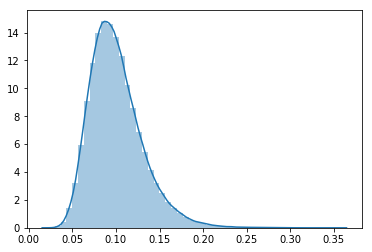

In [124]:
sns.distplot(lr.predict_proba(train[[col + '_unique' for col in col_list]])[:,1])